# Face Mask Detector

Este notebook implementa uma versão otimizada da CNN MobileNetV2, com o intuito de detectar se a pessoa está ou não está usando máscara, a partir de uma foto. Nessa versão otimizada não se usa Transfer Learning, ou seja, o modelo será treinado do zero. Isso foi feito com o intuito de diminuir o `alpha` para valores ainda menores que os determinados no Transfer Learning, deixando o modelo ainda mais leve a fim de ser possível embarcar na ESP32-CAM.  

## Fases do Projeto
1. **Preparação dos Dados**: Download e pré-processamento.
2. **Data Augmentation**: Essencial aqui, pois vamos aprender do zero.
3. **Treinamento Completo**: Uma única fase longa de treinamento.
4. **Exportação**: Conversão para TFLite (INT8).

---


## 1. Configuração Inicial


In [14]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from collections import Counter
from sklearn.metrics import confusion_matrix
import glob

# Utilitários do Keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Constantes e Hiperparâmetros
BATCH_SIZE = 32
IMG_SIZE = (96, 96) # Tamanho da imagem
IMG_SHAPE = IMG_SIZE + (3,)
SEED = 42

print(f"Versão do TensorFlow: {tf.__version__}")


Versão do TensorFlow: 2.19.0


## 2. Download dos Dados (KaggleHub)


In [15]:
print("Baixando Dataset...")
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")
DATA_DIR = os.path.join(path, "data")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='training',
    seed=SEED
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=SEED
)

class_names = train_dataset.class_names
print(f"Classes: {class_names}")


Baixando Dataset...
Using Colab cache for faster access to the 'face-mask-dataset' dataset.
Found 7553 files belonging to 2 classes.
Using 6043 files for training.
Found 7553 files belonging to 2 classes.
Using 1510 files for validation.
Classes: ['with_mask', 'without_mask']


## 3. Visualização


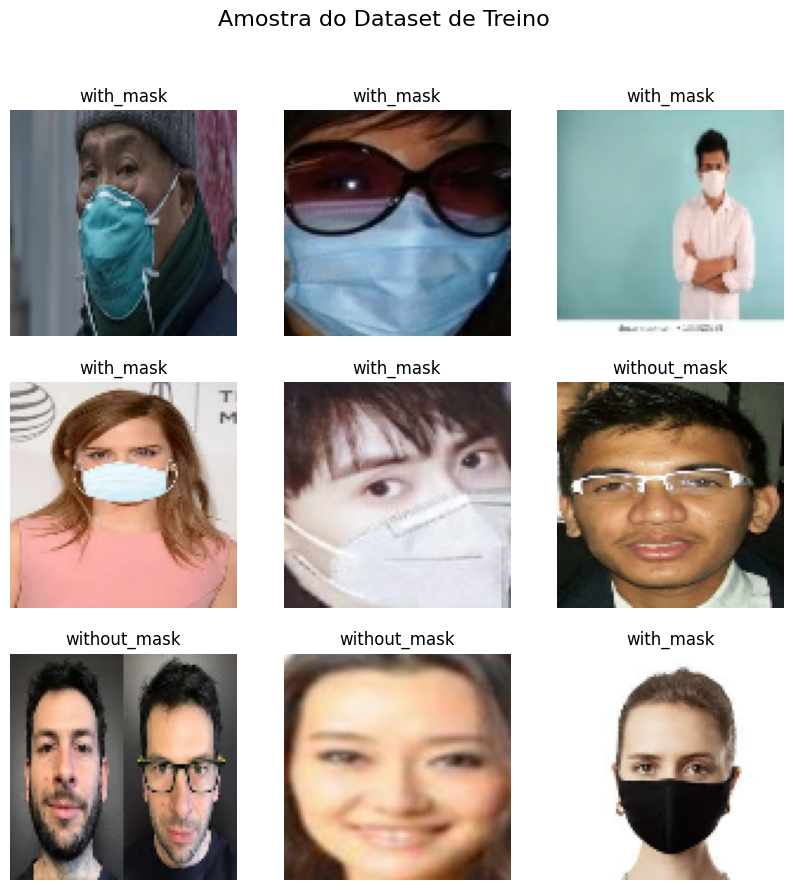

In [16]:
# Visualiza um grid 3x3 com imagens e seus rótulos
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Amostra do Dataset de Treino", fontsize=16)
plt.show()

## 4. Pré-processamento e Augmentation


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

# Data Augmentation (Variações aleatórias para evitar decorar as imagens)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    # Mantivemos o contraste aleatório pois ajuda na robustez
    tf.keras.layers.RandomContrast(0.2),
])

# --- NOVA FUNÇÃO: SEU PROCESSAMENTO PDI ---
def apply_pdi_processing(images):
    """
    Aplica o combo 'Saturação + Sharpening' escolhido visualmente.
    Funciona em batches de imagens.
    """
    # 1. Aumentar Saturação (Realça a cor da máscara vs pele)
    # Factor 1.5 aumenta em 50% a cor
    images = tf.image.adjust_saturation(images, 1.5)

    # 2. Aplicar Sharpening (Filtro de Aguçamento de Bordas)
    # Kernel clássico: [[0, -1, 0], [-1, 5, -1], [0, -1, 0]]

    # Define o kernel 3x3
    kernel = tf.constant([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ], dtype=tf.float32)

    # Prepara o formato para o TensorFlow: (altura, largura, canais_entrada, multiplicador)
    # Expande dimensões para (3, 3, 1, 1)
    kernel = kernel[:, :, tf.newaxis, tf.newaxis]

    # Repete o kernel para os 3 canais RGB -> (3, 3, 3, 1)
    # Isso garante que o filtro seja aplicado no R, no G e no B independentemente
    sharpen_filter = tf.repeat(kernel, 3, axis=2)

    # Aplica a convolução (Depthwise Conv2D é ideal para filtros por canal)
    # O dataset já entrega as imagens em batch (4D), então funciona direto
    images = tf.nn.depthwise_conv2d(images, sharpen_filter, strides=[1,1,1,1], padding='SAME')

    # Importante: Como o sharpening pode criar valores <0 ou >255, fazemos o clip
    images = tf.clip_by_value(images, 0.0, 255.0)

    return images

# Função aplicada no TREINO
def preprocess_train(image, label):
    # 1. Variação aleatória (Data Augmentation)
    image = data_augmentation(image)

    # 2. SEU TRATAMENTO PDI (Melhoria de qualidade)
    image = apply_pdi_processing(image)

    # 3. Normalização para MobileNet (-1 a 1)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Função aplicada na VALIDAÇÃO e TESTE
def preprocess_val(image, label):
    # A validação também deve receber o tratamento de Saturação+Sharp
    # para que a rede "enxergue" o mundo do mesmo jeito que no treino.
    image = apply_pdi_processing(image)

    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Aplica as transformações no dataset
print("Aplicando pipeline de pré-processamento (Augmentation + PDI + Normalização)...")
train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_val, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Aplicando pipeline de pré-processamento (Augmentation + PDI + Normalização)...


Found 7553 files belonging to 2 classes.
Gerando comparativo...


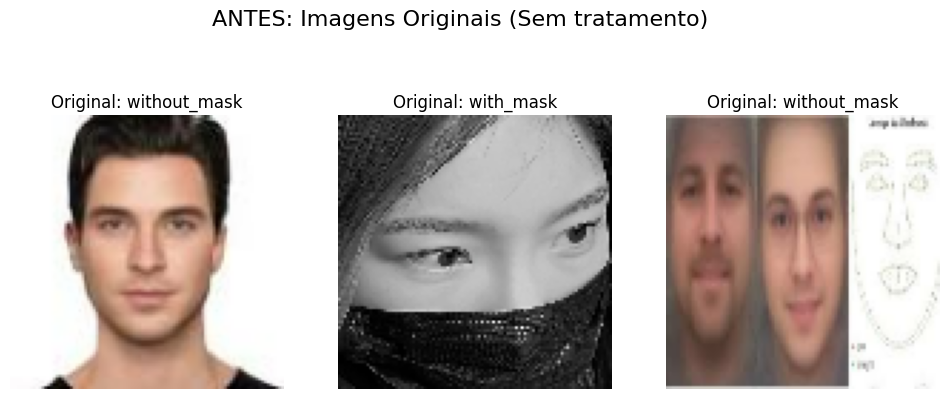

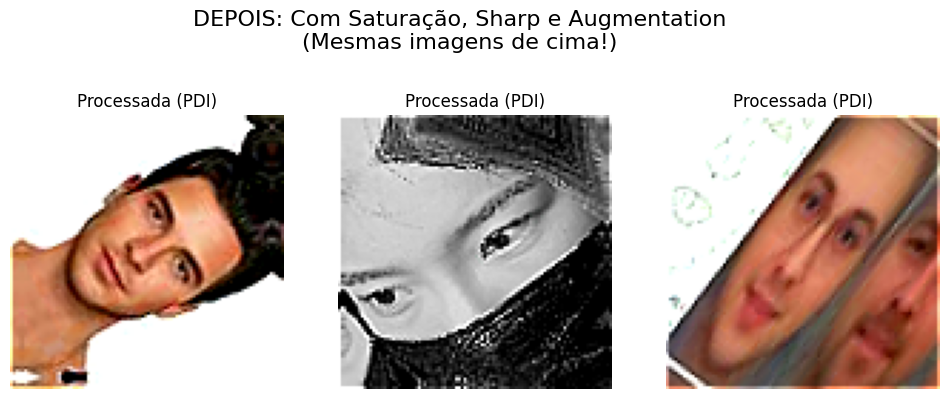

In [18]:
# --- Célula de Comparação Lado a Lado (Antes vs Depois) ---

# 1. Criamos um iterador temporário só para puxar imagens originais do disco
# Usamos o mesmo SEED para garantir repetibilidade
debug_loader = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    shuffle=True,
    batch_size=9,  # Pegamos 9 imagens para visualizar
    image_size=IMG_SIZE,
    seed=SEED
)

# 2. O PULO DO GATO: "Congelamos" um lote de imagens na memória
# Usamos next(iter()) para pegar o primeiro pacote e guardar na variável 'raw_images'
# Agora 'raw_images' não muda mais!
raw_images, raw_labels = next(iter(debug_loader))

# --- PARTE 1: MOSTRAR AS ORIGINAIS (ANTES) ---
print("Gerando comparativo...")
plt.figure(figsize=(12, 5))
plt.suptitle("ANTES: Imagens Originais (Sem tratamento)", fontsize=16)

for i in range(3): # Vamos mostrar apenas 3 para comparar lado a lado
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(raw_images[i].numpy().astype("uint8"))
    plt.title(f"Original: {class_names[raw_labels[i]]}")
    plt.axis("off")
plt.show()

# --- PARTE 2: APLICAR O PROCESSO MANUALMENTE ---
# Agora pegamos as MESMAS 'raw_images' e passamos pelo seu pipeline novo

# A. Aplica Data Augmentation (Girar, Zoom)
processed_imgs = data_augmentation(raw_images)

# B. Aplica seu filtro PDI (Saturação + Sharp)
processed_imgs = apply_pdi_processing(processed_imgs)

# C. Aplica Normalização MobileNet (-1 a 1)
processed_imgs = tf.keras.applications.mobilenet_v2.preprocess_input(processed_imgs)

# --- PARTE 3: MOSTRAR O RESULTADO (DEPOIS) ---
plt.figure(figsize=(12, 5))
plt.suptitle("DEPOIS: Com Saturação, Sharp e Augmentation\n(Mesmas imagens de cima!)", fontsize=16)

for i in range(3):
    ax = plt.subplot(1, 3, i + 1)

    # Desfazemos a normalização (-1 a 1) para (0 a 1) só para o gráfico funcionar
    img_view = (processed_imgs[i] + 1.0) / 2.0
    img_view = tf.clip_by_value(img_view, 0.0, 1.0)

    plt.imshow(img_view.numpy())
    plt.title(f"Processada (PDI)")
    plt.axis("off")

plt.show()

## 5. Construção do Modelo
Isso é o que torna o modelo leve: `weights=None` e `alpha=0.25`.


In [19]:
print("Construindo MobileNetV2 do ZERO (Alpha=0.25)...")

# Base
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights=None,   # <--- Sem pesos pré-treinados
    alpha=0.35       # <--- Rede extremamente pequena
)

# Como não tem pesos pré-treinados, treinamos TUDO desde o início
base_model.trainable = True

inputs = Input(shape=IMG_SHAPE)
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x) # Dropout pequeno pois a rede já é pequena e tem poucos params
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=3e-3), # LR para começar do zero
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()


Construindo MobileNetV2 do ZERO (Alpha=0.25)...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.35_96             │ (None, 3, 3, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,770 (1.57 MB)

 Trainable params: 398,690 (1.52 MB)

 Non-trainable params: 14,080 (55.00 KB)

## 6. Treinamento (Scratch)
Treinamos por mais épocas para compensar a falta de pré-treino.


In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

print("\nIniciando Treinamento Completo...")

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30, # Usando uma grande quantidade de épocas
    callbacks=[early_stop, reduce_lr]
)



Iniciando Treinamento Completo...
Epoch 1/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 168s 672ms/step - accuracy: 0.6368 - loss: 0.7723 - val_accuracy: 0.5086 - val_loss: 0.6938 - learning_rate: 0.0030
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 126s 657ms/step - accuracy: 0.8436 - loss: 0.3683 - val_accuracy: 0.5086 - val_loss: 0.6990 - learning_rate: 0.0030
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 125s 658ms/step - accuracy: 0.8689 - loss: 0.3119 - val_accuracy: 0.5086 - val_loss: 0.7010 - learning_rate: 0.0030
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 126s 664ms/step - accuracy: 0.8791 - loss: 0.2987 - val_accuracy: 0.5086 - val_loss: 0.6984 - learning_rate: 0.0030
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 126s 663ms/step - accuracy: 0.8868 - loss: 0.2755 - val_accuracy: 0.5086 - val_loss: 0.7033 - learning_rate: 0.0030
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.8964 - loss: 0.2506
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
189/189 ━━━━━━━━━━━━━━

## 7. Resultados


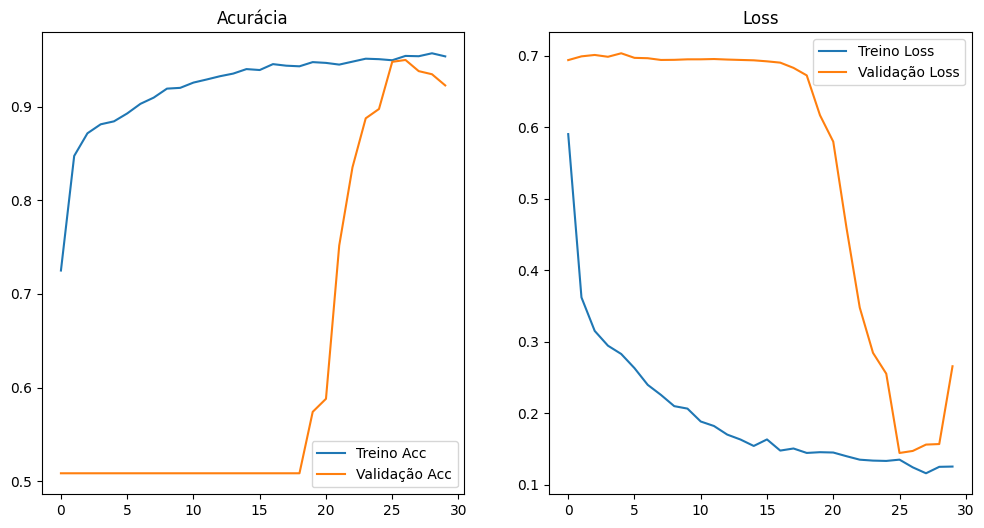


Diagnóstico Final:
Acurácia Treino: 95.35%
Acurácia Validação: 92.25%
GAP: 3.10%
Modelo Generalizando Bem!


In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Treino Acc')
plt.plot(val_acc, label='Validação Acc')
plt.legend()
plt.title('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Treino Loss')
plt.plot(val_loss, label='Validação Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Diagnóstico de Overfitting
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
gap = final_train_acc - final_val_acc

print(f"\nDiagnóstico Final:")
print(f"Acurácia Treino: {final_train_acc*100:.2f}%")
print(f"Acurácia Validação: {final_val_acc*100:.2f}%")
print(f"GAP: {gap*100:.2f}%")

if gap > 0.10:
    print("ALERTA: Possível Overfitting (Gap > 10%)")
else:
    print("Modelo Generalizando Bem!")


## 8. Teste Externo (Prova Real)
Validamos o modelo com um dataset TOTALMENTE NOVO que o modelo nunca viu.


In [22]:
print("\nBaixando Dataset de Teste Externo...")
test_path = kagglehub.dataset_download("belsonraja/face-mask-dataset-with-and-without-mask")
TEST_DIR = os.path.join(test_path, "facemask-dataset", "dataset")

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Aplica apenas o preprocessamento de validação (normalização)
test_dataset = test_dataset.map(preprocess_val).prefetch(AUTOTUNE)

print("\nAvaliando no Dataset Externo...")
external_loss, external_acc = model.evaluate(test_dataset)
print(f"Acurácia no Teste Externo: {external_acc*100:.2f}%")



Baixando Dataset de Teste Externo...


100%|██████████| 137M/137M [00:00<00:00, 179MB/s]

Extracting files...


Found 3833 files belonging to 2 classes.

Avaliando no Dataset Externo...
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.9520 - loss: 0.1327
Acurácia no Teste Externo: 95.20%


### 8.1 Visualização das Predições no Teste


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


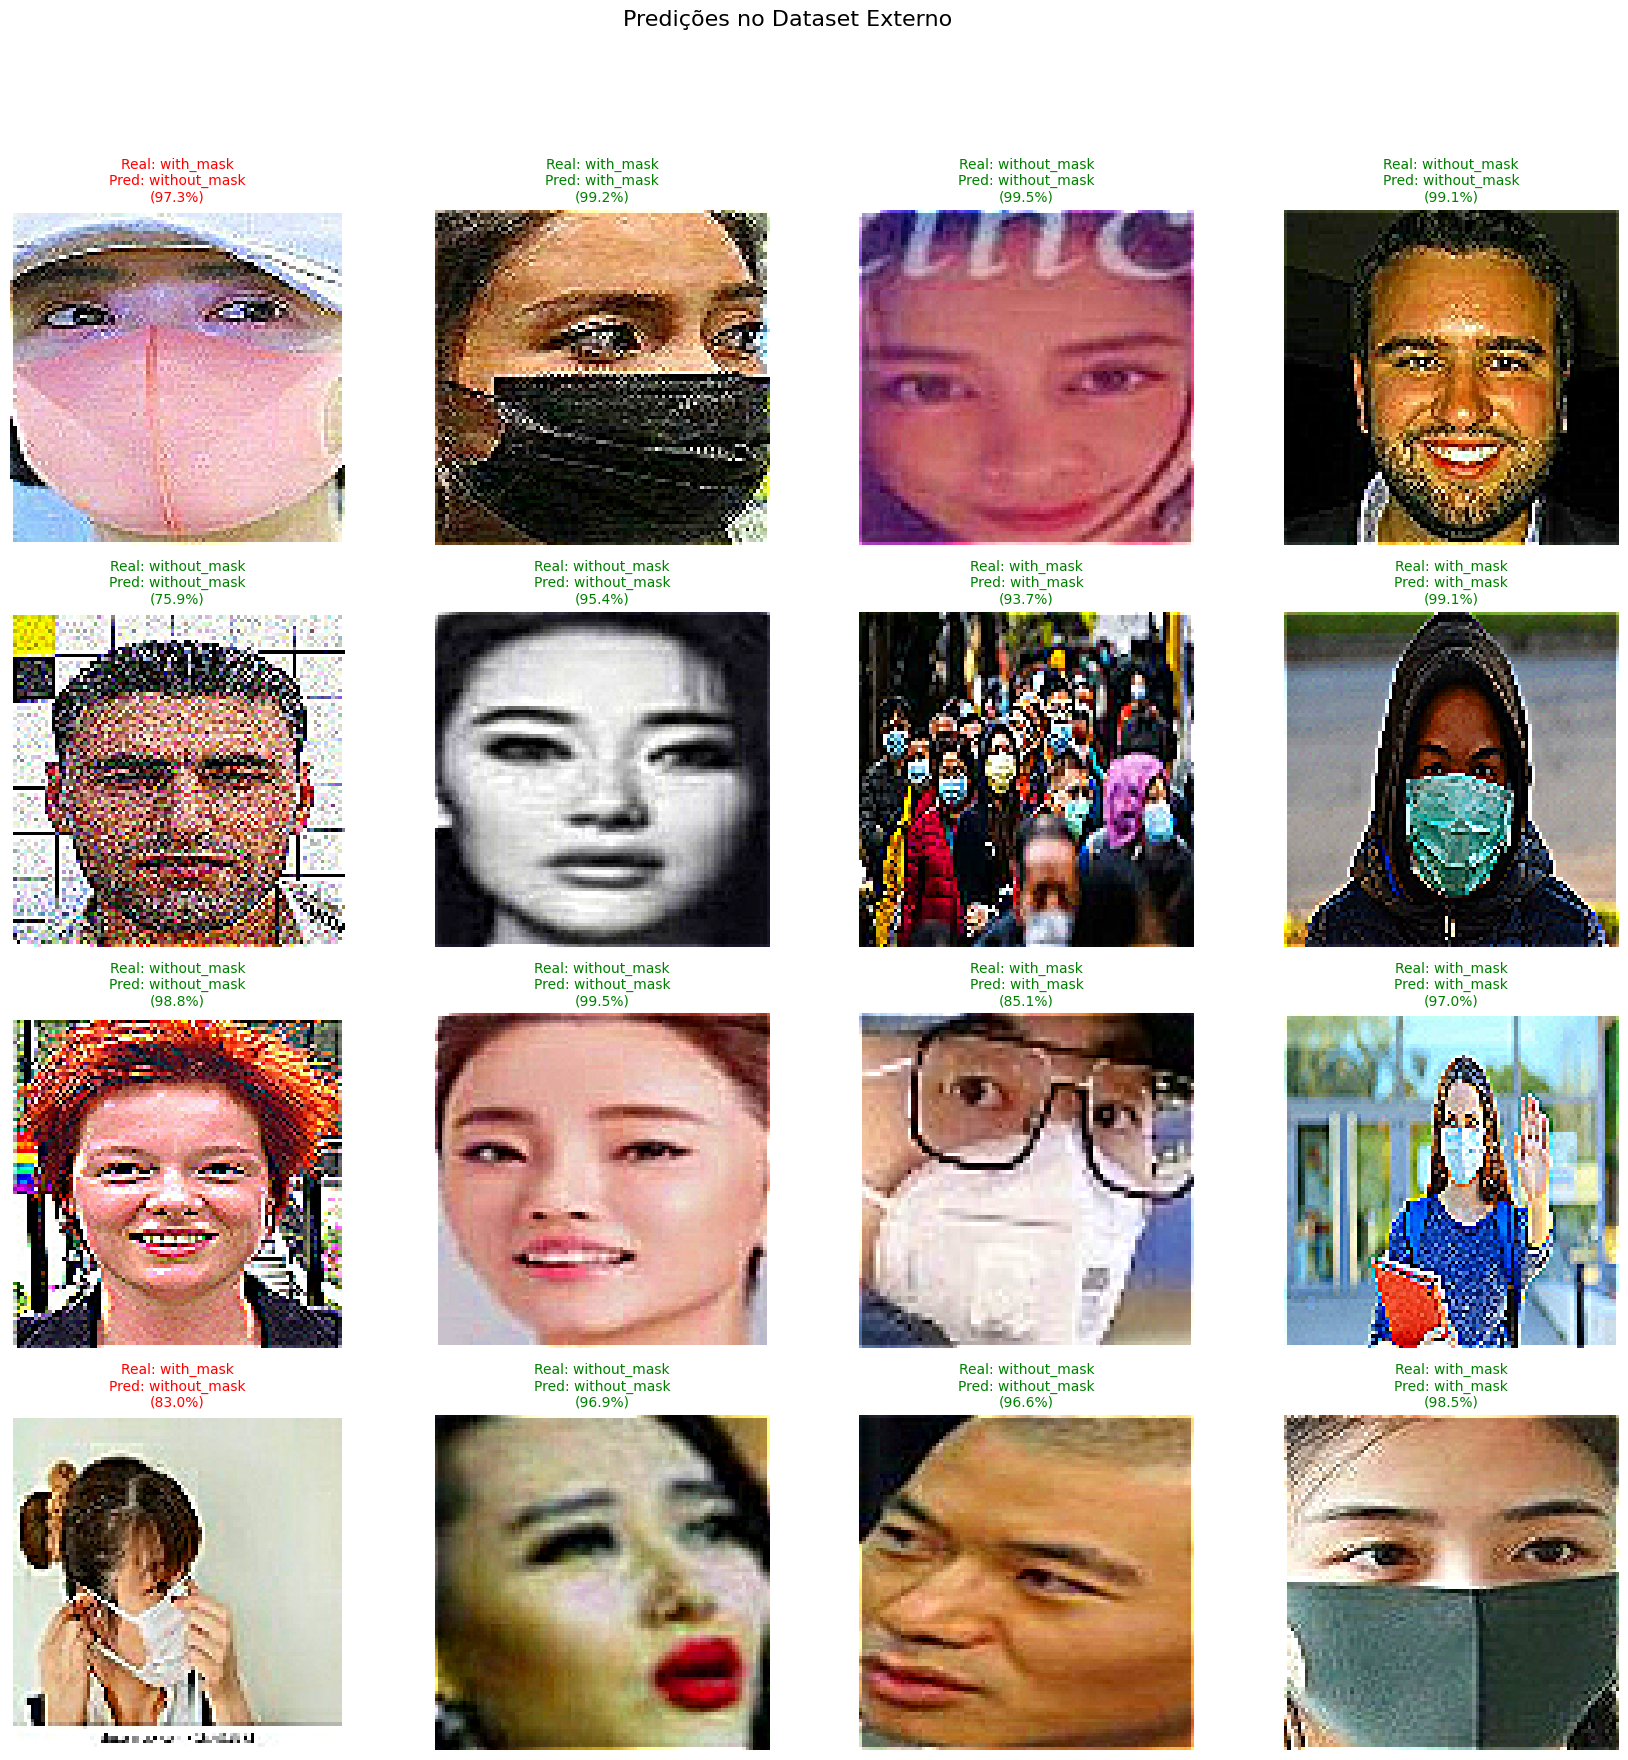

In [23]:
# Pega um batch de imagens
image_batch, label_batch = next(iter(test_dataset))
predictions = model.predict(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

test_class_names = class_names # Classes salvas anteriormente

plt.figure(figsize=(21, 20))
for i in range(min(16, len(image_batch))):
    ax = plt.subplot(4, 4, i + 1)

    # Desnormaliza para mostrar
    img_show = (image_batch[i] + 1) / 2
    plt.imshow(img_show)

    true_label = test_class_names[label_batch[i]]
    pred_label = test_class_names[predicted_classes[i]]
    confidence = np.max(predictions[i]) * 100

    color = "green" if true_label == pred_label else "red"

    plt.title(f"Real: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)", color=color, fontsize=10)
    plt.axis("off")
plt.suptitle("Predições no Dataset Externo", fontsize=16)
plt.show()


## 9. Exportação Otimizada


In [24]:
model.save("detector_leve.keras")

# TFLite Conversion
print("\nConvertendo para TFLite INT8...")
def representative_data_gen():
    for input_value, _ in train_dataset.take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

tflite_path = "detector_leve_int8.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

size_kb = os.path.getsize(tflite_path) / 1024
print(f"Modelo TFLite salvo: {tflite_path}")
print(f"Tamanho Final: {size_kb:.2f} KB")

# Foi dada uma meta de 400kb para o tamanho do tflite quantizado

if size_kb < 400:
    print("SUCESSO! Meta de < 400KB atingida.")
else:
    print("Ainda acima de 400KB.")


Convertendo para TFLite INT8...
Saved artifact at '/tmp/tmp1xyex0x_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_487')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140333350045456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140333350048528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140333350047568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140333350044496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140333350047952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140333350045264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140333350046608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140333350045648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140333350047760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140333350045072: TensorSpec(shape=(), dtype=tf.re

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Modelo TFLite salvo: detector_leve_int8.tflite
Tamanho Final: 609.03 KB
Ainda acima de 400KB.
